# Summary

# Imports

In [ ]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats

In [ ]:
from kmtools import sequence_tools, structure_tools

In [ ]:
%matplotlib inline

In [ ]:
pd.set_option("max_columns", 100)

# Parameters

In [ ]:
NOTEBOOK_PATH = Path('scop_remote_homology_detection')
NOTEBOOK_PATH

In [ ]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

In [ ]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

In [ ]:
HHBLITS_DATABASE_NAME = os.getenv('HHBLITS_DATABASE_NAME')

In [ ]:
DEBUG = "CI" not in os.environ

if DEBUG:
    assert TASK_ID is None and TASK_COUNT is None and HHBLITS_DATABASE_NAME is None
    HHBLITS_DATABASE_NAME = "uniprot20_2016_02"
else:
    assert HHBLITS_DATABASE_NAME is not None
    
DEBUG, HHBLITS_DATABASE_NAME

In [ ]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

# `DATAPKG`

In [ ]:
DATAPKG = {}

In [ ]:
DATAPKG['hhsuite-wstructure'] = {
    'adjacency_matrix_subset_sample':
        Path(os.environ['DATAPKG_OUTPUT_DIR'])
        .joinpath(
            "hhsuite-wstructure",
            "master",
            "adjacency_matrix_subset_sample"),
    'run_hhsearch-scop95':
        Path(os.environ['DATAPKG_OUTPUT_DIR'])
        .joinpath(
            "hhsuite-wstructure",
#             "master",
            "ef390fd78ef217bf5cdd81812be9e849bdce7f77",
            f"run_hhsearch-{HHBLITS_DATABASE_NAME}-scop95"),
    'run_hhsearch-scop40':
        Path(os.environ['DATAPKG_OUTPUT_DIR'])
        .joinpath(
            "hhsuite-wstructure",
#             "master",
            "ef390fd78ef217bf5cdd81812be9e849bdce7f77",
            f"run_hhsearch-{HHBLITS_DATABASE_NAME}-scop40")
}

# Workspace

## Load data

### `adjacency_matrix_df`

In [ ]:
adjacency_matrix_df = (
    pq.ParquetDataset(
        list(
            DATAPKG['hhsuite-wstructure']['adjacency_matrix_subset_sample']
            .joinpath("adjacency_matrix_subset_sample.parquet")
            .glob("*.parquet")
        )
    )
    .read()
    .to_pandas()
    .set_index("__index_level_0__")
)

### `scop95_df`

In [ ]:
scop95_df = (
    pq.ParquetDataset(
        list(
            DATAPKG['hhsuite-wstructure']['run_hhsearch-scop95']
            .glob("hhsearch_output_?.parquet")
        ) + 
        list(
            DATAPKG['hhsuite-wstructure']['run_hhsearch-scop95']
            .glob("hhsearch_output_??.parquet")
        )
    )
    .read_pandas()
    .to_pandas()
)

In [16]:
display(scop95_df.head(2))
print(len(scop95_df))

### `scop40_df`

In [17]:
files = list(
    DATAPKG['hhsuite-wstructure']['run_hhsearch-scop40']
    .glob("hhsearch_output_?.parquet")
) + list(
    DATAPKG['hhsuite-wstructure']['run_hhsearch-scop40']
    .glob("hhsearch_output_??.parquet")
)

assert len(files) == 10

scop40_df = (
    pq.ParquetDataset(files)
    .read_pandas()
    .to_pandas()
)

In [18]:
display(scop40_df.head(2))
print(len(scop40_df))

a3m_file addss_extra_args  \
358983495  358983495.withss.a3m\n>ss_pred PSIPRED predict...                    
258783533  258783533.withss.a3m\n>ss_pred PSIPRED predict...                    

                                        hhblits_database_dir  \
358983495  /scratch/strokach/datapkg_input_dir/hh-databas...   
258783533  /scratch/strokach/datapkg_input_dir/hh-databas...   

          hhblits_extra_args  \
358983495     -n 3 -mact 0.5   
258783533     -n 3 -mact 0.5   

                                            hhblits_hhr_file  \
358983495  358983495.hhr\nQuery         358983495\nMatch_...   
258783533  258783533.hhr\nQuery         258783533\nMatch_...   

          hhfilter_extra_args  \
358983495                       
258783533                       

                                                    hhm_file  \
358983495  358983495.hhm\nHHsearch 1.5\nNAME  358983495\n...   
258783533  258783533.hhm\nHHsearch 1.5\nNAME  258783533\n...   

          hhmake_extra_args  \
358983495                     
258783533                     

                                       hhsearch_database_dir hhsearch_error  \
358983495  /scratch/strokach/datapkg_input_dir/hh-databas...           None   
258783533  /scratch/strokach/datapkg_input_dir/hh-databas...           None   

                             hhsearch_extra_args  \
358983495  -e 3 -loc -realign -mact 0.35 -alt 10   
258783533  -e 3 -loc -realign -mact 0.35 -alt 10   

                                           hhsearch_hhr_file  \
358983495  358983495.hhsearch.hhr\nQuery         35898349...   
258783533  258783533.hhsearch.hhr\nQuery         25878353...   

                                           hhsearch_tab_file  \
358983495  358983495.hhsearch.tab\n>d1w98b2 a.74.1.1 (B:8...   
258783533  258783533.hhsearch.tab\n>d1w98b2 a.74.1.1 (B:8...   

                                               sequence_file temp_dir  
358983495  358983495.fasta\n> 358983495\nSDSVFGTFQQSLTSHM...           
258783533  258783533.fasta\n> 258783533\nMSRFCSNLCLPKQVQM...

7134


## Sanity checks

In [19]:
# hhsearch failed with error for scop40
assert len(adjacency_matrix_df) == len(scop95_df) == len(scop40_df), (
    len(adjacency_matrix_df), len(scop95_df), len(scop40_df),
)

# Analyse hhserach results

In [20]:
hits = sequence_tools.parse_hhr_data(scop95_df.iloc[0]['hhsearch_hhr_file'].split('\n'))

In [21]:
hits[0]

HHRAlignment(query_id='358983495', query_length=104, query_neff=9.5, template_id='d1w98b2', template_length=98, template_info='>d1w98b2 a.74.1.1 (B:88-227) G1/S-specific cyclin-E1 {Human (Homo sapiens) [TaxId: 9606]}', template_neff=10.1, query_ali='FQQSLTSHMRKLLGTWMFSVCQEYNLEPNVVALALNLLDRLLLIK-QVSKEHFQKTGSACLLVASKLRSLTPISTSSLCYAAADSFSRQELIDQEKEL', query_ss_pred='', template_ali='QHPLLQPKMRAILLDWLMEVCEVYKLHRETFYLAQDFFDRYMATQENVVKTLLQLIGISSLFIAAKLEEIYPPKLHQFAYVTDGACSGDEILTMELMI', template_ss_pred='', template_ss_dssp='', ali_confidence='578999999999999999999999999999999999999999998 8899999999999999999999988888999999998999999999999875', query_start=8, query_end=104, template_start=34, template_end=131, probability=99.8, evalue=6.9e-25, score=129.82, aligned_cols=97, identity=0.27, similarity=0.484, sum_probs=92.3)

## Load adjacency matrix data

### `adjacency_matrix_df`

In [22]:
adjacency_matrix_subset_sample_files = (
    DATAPKG['hhsuite-wstructure']['adjacency_matrix_subset_sample']
    .joinpath("adjacency_matrix_subset_sample.parquet")
)

In [23]:
assert len(list(adjacency_matrix_subset_sample_files.glob("*.parquet"))) == 1

In [24]:
adjacency_matrix_df = (
    pq.read_table(next(adjacency_matrix_subset_sample_files.glob("*.parquet")))
    .to_pandas()
)

In [25]:
display(adjacency_matrix_df.head(1))
print(len(adjacency_matrix_df))

__index_level_0__     uniparc_id  \
0          871269249  UPI0001752786   

                                            sequence database  \
0  PMVERQDTDSCLVYGGQQMILTGQNFTSESKVVFTEKTTDGQQIWE...   Gene3D   

              interpro_name interpro_id  domain_start  domain_end  \
0  Immunoglobulin-like fold   IPR013783           180         256   

   domain_length structure_id  model_id chain_id  pc_identity  \
0             77         1A02       0.0        C        100.0   

   alignment_length  mismatches  gap_opens  q_start  q_end  s_start  s_end  \
0              77.0         0.0        0.0      1.0   77.0    180.0  256.0   

   evalue_log10  bitscore                                               qseq  \
0    -50.221849     164.0  PMVERQDTDSCLVYGGQQMILTGQNFTSESKVVFTEKTTDGQQIWE...   

                                                sseq  \
0  PMVERQDTDSCLVYGGQQMILTGQNFTSESKVVFTEKTTDGQQIWE...   

                                                 a2b  \
0  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   

                                                 b2a  \
0  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   

                                       residue_idx_1  \
0  [179.0, 179.0, 179.0, 179.0, 179.0, 180.0, 180...   

                                       residue_idx_2  \
0  [180.0, 181.0, 202.0, 203.0, 204.0, 179.0, 181...   

                                        residue_id_1  \
0  [201.0, 201.0, 201.0, 201.0, 201.0, 202.0, 202...   

                                        residue_id_2  \
0  [202.0, 203.0, 224.0, 225.0, 226.0, 201.0, 203...   

                                        residue_aa_1  \
0  [P, P, P, P, P, M, M, M, M, M, M, M, M, V, V, ...   

                                        residue_aa_2  \
0  [M, V, Q, N, F, P, V, E, T, G, Q, N, F, P, M, ...   

                             residue_idx_1_corrected  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...   

                             residue_idx_2_corrected  
0  [1.0, 2.0, 23.0, 24.0, 25.0, 0.0, 2.0, 3.0, 21...

7134


## Load hhsearch results

In [26]:
def add_extra_columns(df):
    df['scop_domain'] = df['template_info'].str.split(' ').str[1]
    assert (df['scop_domain'].str.count('\.') == 3).all()
    
    df['query_id'] = df['query_id'].astype(int)

    df['unique_id'] = (
        df["query_id"].astype(str) + "-" +
        df["query_start"].astype(str) + ":" +
        df["query_end"].astype(str) + '-' +
        df["template_id"] + "-" +
        df["template_start"].astype(str) + ":" +
        df["template_end"].astype(str)
    )
    assert len(df['unique_id']) == len(df['unique_id'].drop_duplicates())

    df['query_match_length'] = df['query_ali'].str.replace('-', '').str.len()
    
    df['template_match_length'] = df['template_ali'].str.replace('-', '').str.len()
    
    df['identity_calc'] = df.apply(
        lambda row: 
            sum(a == b for a, b in zip(row['query_ali'], row['template_ali']) if a != '-') /
            len(row['query_ali'].replace('-', '')),
        axis=1,
    )
    
    df['coverage_calc'] = df['query_match_length'] / df['query_length']

### `scop95_hhsearch_best_hit`

In [33]:
scop95_hhsearch_best_hit = pd.DataFrame(
    data=(
        vars(d[0])
        for d in scop95_df['hhsearch_hhr_file'].apply(lambda s: sequence_tools.parse_hhr_data(s.split('\n')))
        if d
    )
)

In [34]:
add_extra_columns(scop95_hhsearch_best_hit)

In [35]:
display(scop95_hhsearch_best_hit.head(1))
print(len(scop95_hhsearch_best_hit))

ali_confidence  aligned_cols  \
0  578999999999999999999999999999999999999999998 ...            97   

         evalue  identity  probability  \
0  6.900000e-25      0.27         99.8   

                                           query_ali  query_end   query_id  \
0  FQQSLTSHMRKLLGTWMFSVCQEYNLEPNVVALALNLLDRLLLIK-...        104  358983495   

   query_length  query_neff query_ss_pred  query_start   score  similarity  \
0           104         9.5                          8  129.82       0.484   

   sum_probs                                       template_ali  template_end  \
0       92.3  QHPLLQPKMRAILLDWLMEVCEVYKLHRETFYLAQDFFDRYMATQE...           131   

  template_id                                      template_info  \
0     d1w98b2  >d1w98b2 a.74.1.1 (B:88-227) G1/S-specific cyc...   

   template_length  template_neff template_ss_dssp template_ss_pred  \
0               98           10.1                                     

   template_start scop_domain                       unique_id  \
0              34    a.74.1.1  358983495-8:104-d1w98b2-34:131   

   query_match_length  template_match_length  identity_calc  coverage_calc  
0                  97                     98       0.268041       0.932692

7133


### `scop40_hhsearch_all_hits`

In [36]:
scop40_hhsearch_all_hits = pd.DataFrame(
    data=(
        (vars(d) if d else {})
        for dd in scop40_df['hhsearch_hhr_file'].apply(
            lambda row: sequence_tools.parse_hhr_data(row.split('\n')))
        for d in dd
    )
)

In [37]:
add_extra_columns(scop40_hhsearch_all_hits)

In [38]:
display(scop40_hhsearch_all_hits.head(1))
print(len(scop40_hhsearch_all_hits))

ali_confidence  aligned_cols  \
0  578999999999999999999999999999999999999999998 ...            97   

         evalue  identity  probability  \
0  2.100000e-25      0.27         99.8   

                                           query_ali  query_end   query_id  \
0  FQQSLTSHMRKLLGTWMFSVCQEYNLEPNVVALALNLLDRLLLIK-...        104  358983495   

   query_length  query_neff query_ss_pred  query_start   score  similarity  \
0           104         9.5                          8  129.82       0.484   

   sum_probs                                       template_ali  template_end  \
0       92.3  QHPLLQPKMRAILLDWLMEVCEVYKLHRETFYLAQDFFDRYMATQE...           131   

  template_id                                      template_info  \
0     d1w98b2  >d1w98b2 a.74.1.1 (B:88-227) G1/S-specific cyc...   

   template_length  template_neff template_ss_dssp template_ss_pred  \
0               98           10.1                                     

   template_start scop_domain                       unique_id  \
0              34    a.74.1.1  358983495-8:104-d1w98b2-34:131   

   query_match_length  template_match_length  identity_calc  coverage_calc  
0                  97                     98       0.268041       0.932692

79684


## Select thresholds

### `scop95_hhsearch_best_hit_final`

In [39]:
scop95_hhsearch_best_hit_final = scop95_hhsearch_best_hit[
    (scop95_hhsearch_best_hit['identity_calc'] > 0.8) &
    (scop95_hhsearch_best_hit['coverage_calc'] > 0.6) &
    (scop95_hhsearch_best_hit['query_match_length'] >= 64) &
    (scop95_hhsearch_best_hit['template_match_length'] >= 64)
].copy()

print(len(scop95_hhsearch_best_hit_final))

967


### `scop40_hhsearch_all_hits_final`

In [40]:
scop40_hhsearch_all_hits_final = scop40_hhsearch_all_hits[
    scop40_hhsearch_all_hits['query_id'].isin(scop95_hhsearch_best_hit_final['query_id']) &
    (scop40_hhsearch_all_hits['identity_calc'] < 0.20) &
    (scop40_hhsearch_all_hits['query_match_length'] >= 64) &
    (scop40_hhsearch_all_hits['template_match_length'] >= 64)
].copy()

print(len(scop40_hhsearch_all_hits_final))

469


In [41]:
plot_rc = {
    "axes.labelsize": "x-large",
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "legend.fontsize": "large"
}

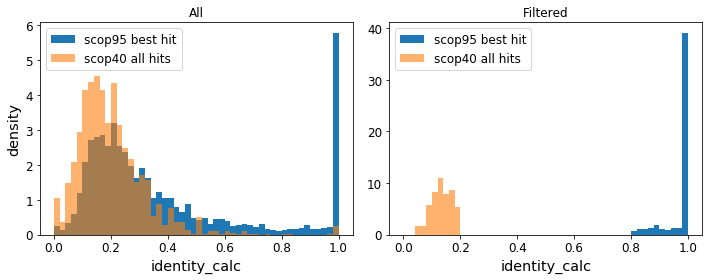

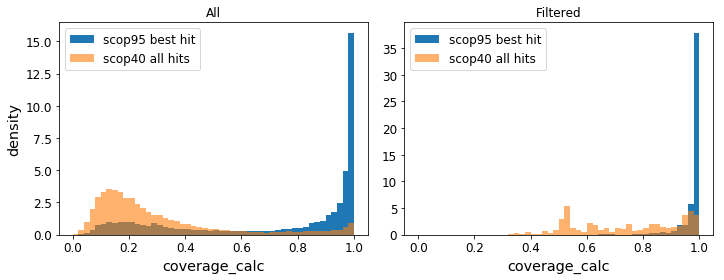

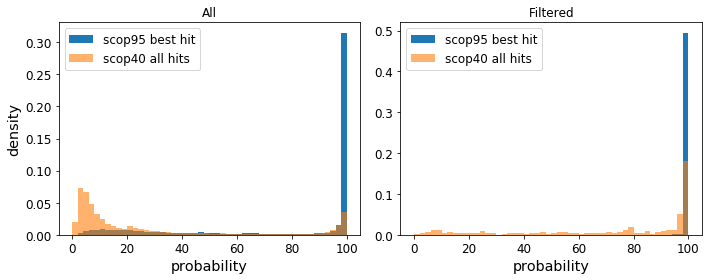

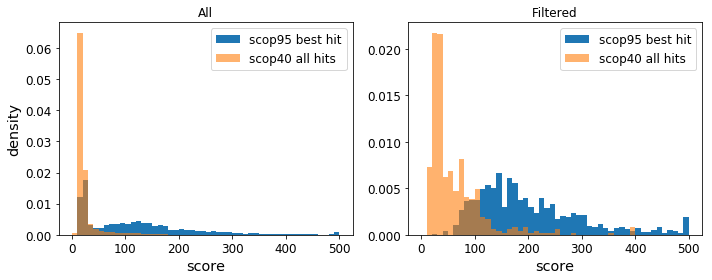

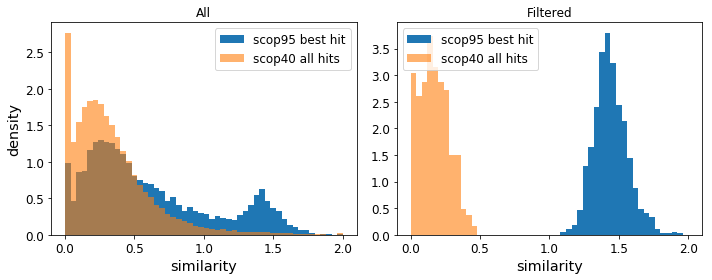

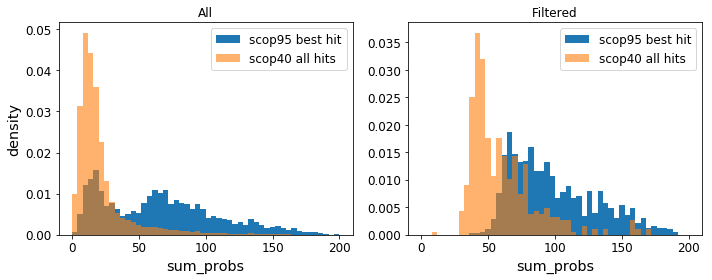

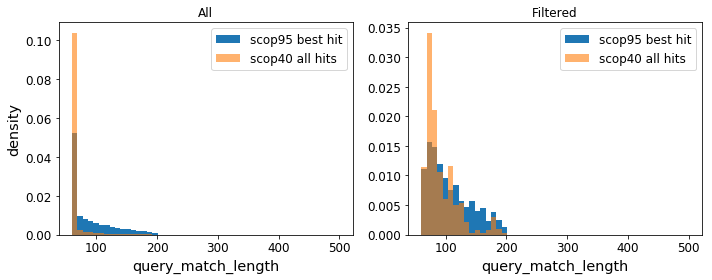

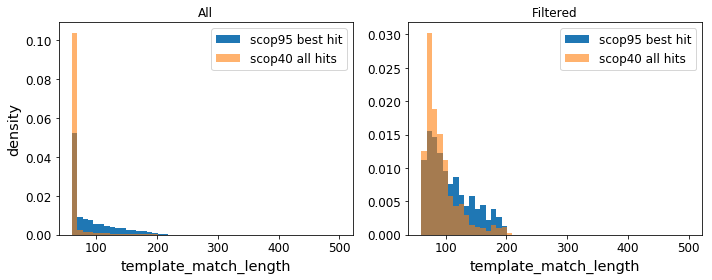

In [42]:
columns_to_plot = {
    'identity': {'kwargs': {'range': (0, 1)}},
    'identity_calc': {'kwargs': {'range': (0, 1)}},
    'coverage_calc': {'kwargs': {'range': (0, 1)}},
    'probability': {'kwargs': {'range': (0, 100)}},
    'evalue': {
        'kwargs': {'range': (-30, 1)},
        'fn': lambda s, min_, max_: np.clip(np.log10(s), min_, max_)},
    'score': {'kwargs': {'range': (0, 500)}},
    'similarity': {'kwargs': {'range': (0, 2)}},
    'sum_probs': {'kwargs': {'range': (0, 200)}},
    "query_match_length": {'kwargs': {'range': (60, 500)}},
    "template_match_length": {'kwargs': {'range': (60, 500)}},
}


for key, value in columns_to_plot.items():
    kwargs = {"bins": 50, "density": True, **value['kwargs']}
    fn = value.get("fn", lambda s, min_, max_: np.clip(s, min_, max_))

    with plt.rc_context(rc=plot_rc):
        fg, axs = plt.subplots(1, 2, figsize=(10, 4))

        plt.sca(axs[0])
        plt.hist(
            fn(scop95_hhsearch_best_hit[key], kwargs['range'][0], kwargs['range'][1]),
            label='scop95 best hit', **kwargs)
        plt.hist(
            fn(scop40_hhsearch_all_hits[key], kwargs['range'][0], kwargs['range'][1]),
            label='scop40 all hits', alpha=0.6, **kwargs)
        plt.xlabel(key)
        plt.ylabel("density")
        plt.legend()
        plt.title("All")
#         plt.show()

        plt.sca(axs[1])
        plt.hist(
            fn(scop95_hhsearch_best_hit_final[key], kwargs['range'][0], kwargs['range'][1]),
            label='scop95 best hit', **kwargs)
        plt.hist(
            fn(scop40_hhsearch_all_hits_final[key], kwargs['range'][0], kwargs['range'][1]),
            label='scop40 all hits', alpha=0.6, **kwargs)
        plt.xlabel(key)
        plt.title("Filtered")
        
        plt.tight_layout()
        plt.legend()
        plt.show()

### `query_id_to_scop_domain`

In [43]:
query_id_to_scop_domain = {
    row.query_id: row.scop_domain
    for row in scop95_hhsearch_best_hit_final.itertuples()
}
assert len(query_id_to_scop_domain) == len(scop95_hhsearch_best_hit_final)

In [44]:
print(len(query_id_to_scop_domain))

967


In [45]:
list(query_id_to_scop_domain.items())[:3]

[(182362022, 'd.51.1.1'), (280534567, 'd.51.1.1'), (352221408, 'd.51.1.1')]

## Create final dataset

### `remote_homology_dataset`

In [46]:
adj_columns = [
    'query_id',
    'structure_id', 'model_id', 'chain_id',
    'q_start', 'q_end', 'qseq',
    's_start', 's_end', 'sseq',
    'residue_idx_1_corrected', 'residue_idx_2_corrected',
]

remote_homology_dataset = (
    scop40_hhsearch_all_hits_final
    .merge(
        adjacency_matrix_df.rename(columns={'__index_level_0__': 'query_id'})[adj_columns],
        on=['query_id']
    )
)                                                                               

In [47]:
scop40_hhsearch_all_hits_final['query_id'] = scop40_hhsearch_all_hits_final['query_id'].astype(int)

In [48]:
remote_homology_dataset['scop_domain_canonical'] = (
    remote_homology_dataset['query_id']
    .map(query_id_to_scop_domain)
)

In [49]:
display(remote_homology_dataset.head(1))
print(len(remote_homology_dataset))

ali_confidence  aligned_cols  \
0  356788999999999999999999999999999999753     47...            67   

         evalue  identity  probability  \
0  1.300000e-12      0.13        98.65   

                                           query_ali  query_end   query_id  \
0  ITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGSEDR...         75  182362022   

   query_length  query_neff query_ss_pred  query_start  score  similarity  \
0            79         9.5                          4  62.76       0.261   

   sum_probs                                       template_ali  template_end  \
0       58.8  PRIYVKVKPERLGAVIGPRGEVKAEIMRRTGTVITVDTE-----NS...            74   

  template_id                                      template_info  \
0     d1tuaa1  >d1tuaa1 d.51.1.1 (A:1-84) Hypothetical protei...   

   template_length  template_neff template_ss_dssp template_ss_pred  \
0               72           10.0                                     

   template_start scop_domain                    unique_id  \
0               3    d.51.1.1  182362022-4:75-d1tuaa1-3:74   

   query_match_length  template_match_length  identity_calc  coverage_calc  \
0                  72                     72          0.125       0.911392   

  structure_id  model_id chain_id  q_start  q_end  \
0         1KHM       0.0        A      1.0   79.0   

                                                qseq  s_start  s_end  \
0  GPIITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGS...     11.0   89.0   

                                                sseq  \
0  GPIITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGS...   

                             residue_idx_1_corrected  \
0  [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...   

                             residue_idx_2_corrected scop_domain_canonical  
0  [1.0, 2.0, 55.0, 0.0, 2.0, 3.0, 55.0, 56.0, 0....              d.51.1.1

469


In [50]:
for feature in columns_to_plot:
    corr = stats.spearmanr(
        remote_homology_dataset[feature],
        remote_homology_dataset['scop_domain'] == remote_homology_dataset['scop_domain_canonical']
    )
    print(f"{feature:>16s}: {corr.correlation: .3f} ({corr.pvalue:.3e})")

        identity:  0.378 (2.097e-17)
   identity_calc:  0.372 (7.661e-17)
   coverage_calc:  0.483 (8.243e-29)
     probability:  0.543 (2.509e-37)
          evalue: -0.543 (2.467e-37)
           score:  0.524 (1.919e-34)
      similarity:  0.434 (5.367e-23)
       sum_probs:  0.486 (3.935e-29)
query_match_length:  0.294 (8.956e-11)
template_match_length:  0.283 (4.329e-10)


In [51]:
remote_homology_dataset['query_ali_len_1'] = remote_homology_dataset['query_ali'].str.len()
remote_homology_dataset['query_ali_len_2'] = remote_homology_dataset['query_ali'].str.replace('-', '').str.len()
remote_homology_dataset['query_ali_len_3'] = remote_homology_dataset['query_end'] - remote_homology_dataset['query_start'] + 1

print("Some messed up rows:")
display(remote_homology_dataset[
    remote_homology_dataset['query_ali_len_2'] != remote_homology_dataset['query_ali_len_3']
])

remote_homology_dataset = remote_homology_dataset[remote_homology_dataset['query_ali_len_2'] == remote_homology_dataset['query_ali_len_3']]

Some messed up rows:


ali_confidence  aligned_cols  evalue  \
285  4568                                          ...            14    11.0   

     identity  probability                                          query_ali  \
285      0.21         8.46  VPVG.............................................   

     query_end   query_id  query_length  query_neff query_ss_pred  \
285         85  127402822            91         7.5                 

     query_start  score  similarity  sum_probs  \
285           72  15.86       -0.09       10.0   

                                          template_ali  template_end  \
285  VIYXvavgyaadiavyrlddpryfglhdpaigpvasggrpsvmalf...           130   

    template_id                                      template_info  \
285     d2paja1  >d2paja1 b.92.1.4 (A:10-69,A:406-484) Hypothet...   

     template_length  template_neff template_ss_dssp template_ss_pred  \
285               73            8.8                                     

     template_start scop_domain                       unique_id  \
285              58    b.92.1.4  127402822-72:85-d2paja1-58:130   

     query_match_length  template_match_length  identity_calc  coverage_calc  \
285                  73                     73       0.041096       0.802198   

    structure_id  model_id chain_id  q_start  q_end  \
285         1IQ0       0.0        A      1.0   91.0   

                                                  qseq  s_start  s_end  \
285  MLRRALEEAIAQALKEMGVPVRLKVARAPKDKPGDYGVPLFALAKE...      1.0   91.0   

                                                  sseq  \
285  MLRRALEEAIAQALKEMGVPVRLKVARAPKDKPGDYGVPLFALAKE...   

                               residue_idx_1_corrected  \
285  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...   

                               residue_idx_2_corrected scop_domain_canonical  \
285  [1.0, 2.0, 3.0, 4.0, 66.0, 89.0, 0.0, 2.0, 3.0...              d.67.2.1   

     query_ali_len_1  query_ali_len_2  query_ali_len_3  
285               73               73               14

In [52]:
remote_homology_dataset['query_sequence_matches'] = (
    remote_homology_dataset.apply(
        lambda row: 
            row['query_ali'].replace('-', '') ==
            row['qseq'].replace('-', '')[row['query_start'] - 1:row['query_end']],
        axis=1
    )
)

remote_homology_dataset['template_sequence_matches'] = (
    remote_homology_dataset.apply(
        lambda row: 
            row['query_ali'].replace('-', '') ==
            row['sseq'].replace('-', '')[row['query_start'] - 1:row['query_end']],
        axis=1
    )
)


assert remote_homology_dataset['query_sequence_matches'].all()
assert remote_homology_dataset['template_sequence_matches'].all()

In [53]:
def get_crossmapping(a, b):
    try:
        a2b, b2a = sequence_tools.get_crossmapping(a, b, skip_mismatch=False)
    except Exception as e:
        print(e)
        return None, None
    a2b = [(int(i) - 1 if i.isdigit() else None) for i in a2b.split(',')]
    b2a = [(int(i) - 1 if i.isdigit() else None) for i in b2a.split(',')]
    return a2b, b2a


remote_homology_dataset['a2b'], remote_homology_dataset['b2a'] = list(zip(*
    remote_homology_dataset.apply(
        lambda row: get_crossmapping(row['query_ali'], row['template_ali']),
        axis=1)
))

remote_homology_dataset = remote_homology_dataset[
    remote_homology_dataset['a2b'].notnull() &
    remote_homology_dataset['b2a'].notnull()
]

In [54]:
remote_homology_dataset['sequence'] = remote_homology_dataset['template_ali'].str.replace('-', '')

In [55]:
remote_homology_dataset['query_adjacency_idx_1'] = (
    remote_homology_dataset.apply(
        lambda row: [
            int(a - row['query_start'] + 1)
            for (a, b) in zip(row['residue_idx_1_corrected'], row['residue_idx_2_corrected'])
            if a >= (row['query_start'] - 1)
                and b >= (row['query_start'] - 1)
                and a < (row['query_end'])
                and b < (row['query_end'])
        ],
        axis=1
    )
)


remote_homology_dataset['query_adjacency_idx_2'] = (
    remote_homology_dataset.apply(
        lambda row: [
            int(b - row['query_start'] + 1)
            for (a, b) in zip(row['residue_idx_1_corrected'], row['residue_idx_2_corrected'])
            if a >= (row['query_start'] - 1)
                and b >= (row['query_start'] - 1)
                and a < (row['query_end'])
                and b < (row['query_end'])
        ],
        axis=1
    )
)

In [56]:
remote_homology_dataset['adjacency_idx_1'] = (
    remote_homology_dataset.apply(
        lambda row: [
            row['a2b'].index(a)
            for a, b in zip(row['query_adjacency_idx_1'], row['query_adjacency_idx_2'])
            if a in row['a2b'] and b in row['a2b']
        ],
        axis=1
    )
)

remote_homology_dataset['adjacency_idx_2'] = (
    remote_homology_dataset.apply(
        lambda row: [
            row['a2b'].index(b)
            for a, b in zip(row['query_adjacency_idx_1'], row['query_adjacency_idx_2'])
            if a in row['a2b'] and b in row['a2b']
        ],
        axis=1
    )
)

In [57]:
assert (remote_homology_dataset['adjacency_idx_1'].apply(min) >= 0).all()
assert (remote_homology_dataset['adjacency_idx_2'].apply(min) >= 0).all()

assert (
    remote_homology_dataset['adjacency_idx_1'].apply(max) <
    remote_homology_dataset['sequence'].str.len()
).all()

assert (
    remote_homology_dataset['adjacency_idx_2'].apply(max) <
    remote_homology_dataset['sequence'].str.len()
).all()

In [58]:
remote_homology_dataset.head(1)

ali_confidence  aligned_cols  \
0  356788999999999999999999999999999999753     47...            67   

         evalue  identity  probability  \
0  1.300000e-12      0.13        98.65   

                                           query_ali  query_end   query_id  \
0  ITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGSEDR...         75  182362022   

   query_length  query_neff query_ss_pred  query_start  score  similarity  \
0            79         9.5                          4  62.76       0.261   

   sum_probs                                       template_ali  template_end  \
0       58.8  PRIYVKVKPERLGAVIGPRGEVKAEIMRRTGTVITVDTE-----NS...            74   

  template_id                                      template_info  \
0     d1tuaa1  >d1tuaa1 d.51.1.1 (A:1-84) Hypothetical protei...   

   template_length  template_neff template_ss_dssp template_ss_pred  \
0               72           10.0                                     

   template_start scop_domain                    unique_id  \
0               3    d.51.1.1  182362022-4:75-d1tuaa1-3:74   

   query_match_length  template_match_length  identity_calc  coverage_calc  \
0                  72                     72          0.125       0.911392   

  structure_id  model_id chain_id  q_start  q_end  \
0         1KHM       0.0        A      1.0   79.0   

                                                qseq  s_start  s_end  \
0  GPIITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGS...     11.0   89.0   

                                                sseq  \
0  GPIITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGS...   

                             residue_idx_1_corrected  \
0  [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...   

                             residue_idx_2_corrected scop_domain_canonical  \
0  [1.0, 2.0, 55.0, 0.0, 2.0, 3.0, 55.0, 56.0, 0....              d.51.1.1   

   query_ali_len_1  query_ali_len_2  query_ali_len_3  query_sequence_matches  \
0               77               72               72                    True   

   template_sequence_matches  \
0                       True   

                                                 a2b  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                                 b2a  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            sequence  \
0  PRIYVKVKPERLGAVIGPRGEVKAEIMRRTGTVITVDTENSMVIVE...   

                               query_adjacency_idx_1  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...   

                               query_adjacency_idx_2  \
0  [1, 2, 49, 50, 51, 52, 53, 56, 0, 2, 3, 48, 49...   

                                     adjacency_idx_1  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...   

                                     adjacency_idx_2  
0  [1, 2, 44, 45, 46, 52, 53, 56, 0, 2, 3, 43, 44...

# Save results

In [59]:
columns = (
    list(scop40_hhsearch_all_hits_final.columns) +
    [
        'scop_domain_canonical',
        'a2b', 'b2a',
        'sequence', 'adjacency_idx_1', 'adjacency_idx_2',
    ]
)

output_df = remote_homology_dataset[columns]

display(output_df.head(1))

ali_confidence  aligned_cols  \
0  356788999999999999999999999999999999753     47...            67   

         evalue  identity  probability  \
0  1.300000e-12      0.13        98.65   

                                           query_ali  query_end   query_id  \
0  ITTQVTIPKDLARSIIGKGGQRIKQIRHESGASIKIDEPLEGSEDR...         75  182362022   

   query_length  query_neff query_ss_pred  query_start  score  similarity  \
0            79         9.5                          4  62.76       0.261   

   sum_probs                                       template_ali  template_end  \
0       58.8  PRIYVKVKPERLGAVIGPRGEVKAEIMRRTGTVITVDTE-----NS...            74   

  template_id                                      template_info  \
0     d1tuaa1  >d1tuaa1 d.51.1.1 (A:1-84) Hypothetical protei...   

   template_length  template_neff template_ss_dssp template_ss_pred  \
0               72           10.0                                     

   template_start scop_domain                    unique_id  \
0               3    d.51.1.1  182362022-4:75-d1tuaa1-3:74   

   query_match_length  template_match_length  identity_calc  coverage_calc  \
0                  72                     72          0.125       0.911392   

  scop_domain_canonical                                                a2b  \
0              d.51.1.1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                                 b2a  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            sequence  \
0  PRIYVKVKPERLGAVIGPRGEVKAEIMRRTGTVITVDTENSMVIVE...   

                                     adjacency_idx_1  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...   

                                     adjacency_idx_2  
0  [1, 2, 44, 45, 46, 52, 53, 56, 0, 2, 3, 43, 44...

In [60]:
table = pa.Table.from_pandas(output_df, columns=columns, preserve_index=True)
pq.write_table(table, OUTPUT_PATH.joinpath("remote_homology_dataset.parquet"), version="2.0", flavor="spark")